## 개인 프로젝트 : 악성 댓글 탐지
### 전처리 부분

### 0. 필요한 모듈 불러오기

In [12]:
import pandas as pd

import torch

from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

from wordcloud.wordcloud import FONT_PATH
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import T5ForConditionalGeneration, T5Tokenizer

from tqdm import tqdm
tqdm.pandas()

import re

### 1. 데이터 확인 및 전처리

- 데이터 특징
    - content, label 두 column으로 구성
    - 악성 댓글이면 0, 아니면 1
- 출처: https://github.com/ZIZUN/korean-malicious-comments-dataset

#### 1) 데이터 확인

In [5]:
# 데이터 불러오기

data = pd.read_csv('../datasets/Dataset.csv', sep='\t')

In [7]:
# 결측치 확인

data.isnull().sum()

content     0
lable      25
dtype: int64

In [8]:
# 결측치 있는 행 제거, 인덱스 초기화

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
# label 컬럼명 변경(lable -> label), 자료형 수정(실수 -> 정수)

data.rename(columns={'lable': 'label'}, inplace=True)
data['label'] = data['label'].apply(int)

In [10]:
# 악성 댓글을 1, 아닌 댓글을 0으로 변경

data['label'] = data['label'].apply(lambda x: 1-x)

In [11]:
# 클래스 불균형 정도 확인

data['label'].value_counts(normalize=True)

label
0    0.500451
1    0.499549
Name: proportion, dtype: float64

#### 2) 기초 전처리

Reference
- https://velog.io/@jochedda/NLP-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC

In [3]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }


def clean(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text.strip()


def clean_str(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\n]'         # 특수 기호 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub('\n', '.', string=text)
    return text

In [13]:
data['content'] = data['content'].progress_apply(clean, args=(punct, punct_mapping))
data['content'] = data['content'].progress_apply(clean_str)

100%|██████████| 9975/9975 [00:00<00:00, 119285.12it/s]


#### 3) 맞춤법, 띄어쓰기 수정

Reference
- https://github.com/jongmin-oh/korean-typos-corrector

In [15]:
# 맞춤법 수정 함수 작성

corr_model = T5ForConditionalGeneration.from_pretrained('j5ng/et5-typos-corrector')
tokenizer = T5Tokenizer.from_pretrained('j5ng/et5-typos-corrector')

device = "cuda" if torch.cuda.is_available() else "cpu"

corr_model = corr_model.to(device)

def corrector(sentence, corr_model, tokenizer, device):
    input_encoding = tokenizer("맞춤법을 고쳐주세요: " + sentence, return_tensors="pt")

    input_ids = input_encoding.input_ids.to(device)
    attention_mask = input_encoding.attention_mask.to(device)

    output_encoding = corr_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=5,
        early_stopping=True,
    )

    output_text = tokenizer.decode(output_encoding[0], skip_special_tokens=True)

    return output_text


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [16]:
# 맞춤법, 띄어쓰기 수정

data['content'] = data['content'].progress_apply(corrector, args=(corr_model, tokenizer, device))

100%|██████████| 9975/9975 [2:03:54<00:00,  1.34it/s]  


In [17]:
data.to_csv('../datasets/cleaned_data.csv', index=False)

#### 4) 데이터 분리, 토큰화

In [43]:
data = pd.read_csv('../datasets/cleaned_data.csv')

In [44]:
# 토큰화 함수 작성

def tokenize(sentence):
    okt = Okt()
    pos_token = okt.pos(sentence, stem=True, norm=True)

    exclude_tag_list = ['Josa', 'PreEomi', 'Eomi', 'Punctuation', 'Foreign']
    # 조사, (선어말, 일반)어미, 구두점, 외국어/한자/기타 기호 제거

    after_pos = []

    for token, tag in pos_token:
        if tag not in exclude_tag_list:
            after_pos.append(token)

    return after_pos

In [23]:
X = data['content']
y = data['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=0)

In [24]:
# 토큰화 적용

X_train = X_train.progress_apply(tokenize)
X_val = X_val.progress_apply(tokenize)
X_test = X_test.progress_apply(tokenize)

100%|██████████| 998/998 [00:06<00:00, 148.59it/s]


In [25]:
# 악성 댓글과 악성이 아닌 댓글 따로 합치기

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train_0 = train[train['label'] == 0]
train_1 = train[train['label'] == 1]

#### 5) 시각화

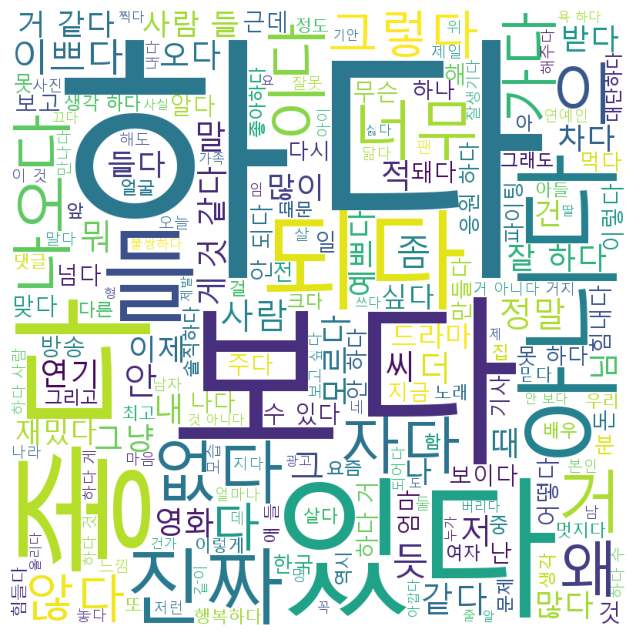

In [26]:
# 악성 아닌 댓글 시각화

text_0 = ' '.join(sum(train_0['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_0 = WordCloud(width=800, height=800,
                        font_path=FONT_PATH,
                        background_color='white',
                        min_font_size=10).generate(text_0)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_0)
plt.axis('off')

plt.show()

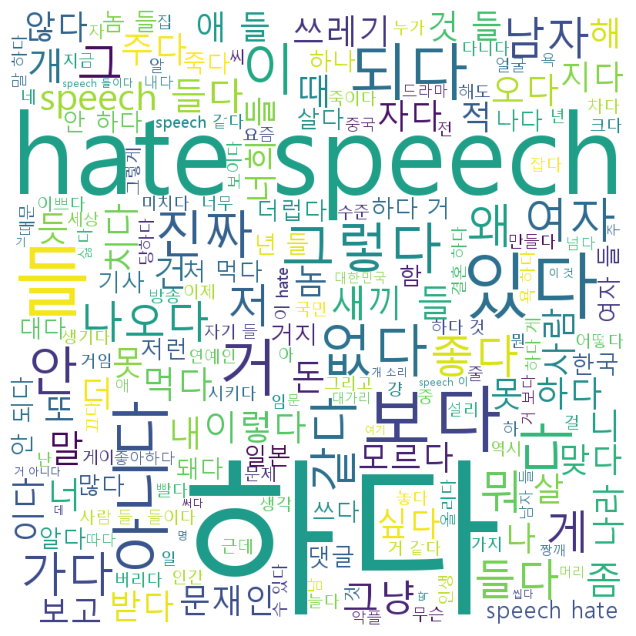

In [27]:
# 악성 댓글 시각화

text_1 = ' '.join(sum(train_1['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_1 = WordCloud(width=800, height=800,
                        font_path=FONT_PATH,
                        background_color='white',
                        min_font_size=10).generate(text_1)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_1)
plt.axis('off')

plt.show()

#### 6) 토큰화 함수 재작성

In [48]:
# '하다'는 자주 나오면서도 대체로 악성 여부를 판별하는 맥락과 무관하므로 불용어 처리

stopwords = ['하다']

In [49]:
# 토큰화 함수 재작성

def tokenize_new(sentence):
    okt = Okt()
    pos_token = okt.pos(sentence, stem=True, norm=True)
    # 정규화, 어간 추출 수행

    exclude_tag_list = ['Josa', 'PreEomi', 'Eomi', 'Punctuation', 'Foreign']
    # 조사, (선어말, 일반)어미, 구두점, 외국어/한자/기타 기호 제거

    after_pos = []

    for token, tag in pos_token:
        if tag not in exclude_tag_list:
            after_pos.append(token)

    tokens = [word for word in after_pos if word not in stopwords]

    return tokens

In [50]:
# 다시 토큰화 진행

X = data['content']
y = data['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=0)

In [51]:
X_train = X_train.progress_apply(tokenize_new)
X_val = X_val.progress_apply(tokenize_new)
X_test = X_test.progress_apply(tokenize_new)

100%|██████████| 998/998 [00:03<00:00, 286.31it/s]


In [52]:
# 악성 댓글과 악성이 아닌 댓글 따로 합치기

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train_0 = train[train['label'] == 0]
train_1 = train[train['label'] == 1]

#### 7) 재시각화

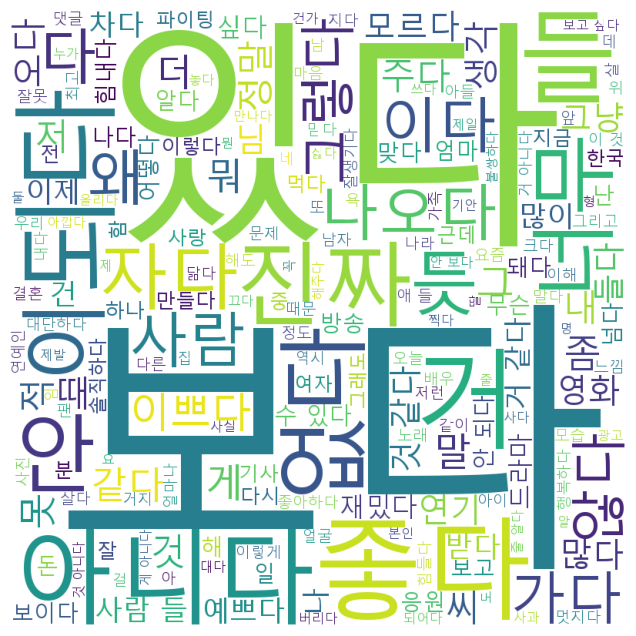

In [54]:
# 악성 댓글 시각화

text_0 = ' '.join(sum(train_0['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_0_new = WordCloud(width=800, height=800,
                            font_path=FONT_PATH,
                            background_color='white',
                            min_font_size=10).generate(text_0)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_0_new)
plt.axis('off')

plt.show()

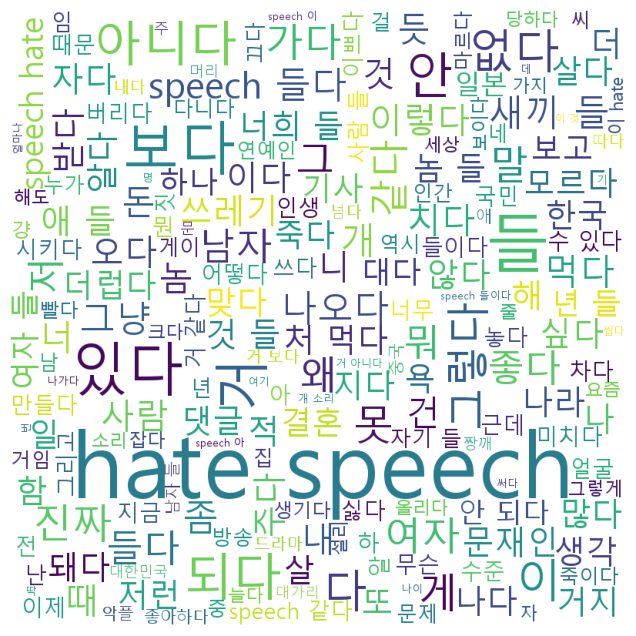

In [55]:
# 악성이 아닌 댓글 시각화

text_1 = ' '.join(sum(train_1['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_1_new = WordCloud(width=800, height=800,
                            font_path=FONT_PATH,
                            background_color='white',
                            min_font_size=10).generate(text_1)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_1_new)
plt.axis('off')

plt.show()

### 2. 데이터 저장

In [56]:
train.to_csv('../datasets/train_data.csv', index=False)
val.to_csv('../datasets/val_data.csv', index=False)
test.to_csv('../datasets/test_data.csv', index=False)